In [1]:
# %matplotlib qt5
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [6]:
import scipy
from functools import partial
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    x = np.reshape(x,(len(x),1))
    # dxdt = -x+J@np.tanh(x)#+I[0]
    dxdt = -x+J@x+I[0]
    return np.squeeze(dxdt)
def odesimulation(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)

In [7]:
''' Parameters used for all networks (reciprocal and chain)'''
### get the current path location and read the data file
import os
strr= os.getcwd()
print(strr)

### define the network parameters of the adjacency matrix
N  = 1500
Kt = int(N*0.2)
J = 1/np.sqrt(N)*0.5  ### TODO: make sure this scalar with David&Stefano's paper
J = 0.00325
ntau   = 10
trials = 30+6
tau_series = np.linspace(0,0.15,ntau)#
### EEII; EEEIII; EEEIII;EEII
switch = 1
## arrays to store results
## norml0_series: norm of left eigenvector(deltaliri = 1)
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
### also have the reconstructed left and right eigenvectors 
htau = tau_series[1]-tau_series[0]
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))

g, gamma =  6, 1/4.0
NE = int(N/(1+gamma))
NI = N-NE#NE*gamma
N  = NE+NI ### update 
ALPHAE, ALPHAI = NE/N, NI/N
KE, KI = int(Kt/(1+gamma)), int(Kt/(1+gamma)*gamma) ### fixed out-degree
ce, ci = KE/NE, KI/NI
print('ce and ci:',ce,ci)
### assert that the differences between ce and ci are smaller than epsilon
epsilon = 1E-2
assert np.abs(ce-ci)<epsilon
# assert ce==ci
c = ce
ji,je = g*J,J 
### define the network parameters of the diluted Gaussian matrix 
ge, gi = np.sqrt(je**2*c*(1-c)*N), np.sqrt(ji**2*c*(1-c)*N) 
hat_sigmae, hat_sigmai = np.sqrt(c*(1-c)), np.sqrt(c*(1-c))### standard deviation of the adjacency matrix
sigmae,sigmai = np.sqrt(c*(1-c)*J**2*N), np.sqrt(c*(1-c)*(-g*J)**2*N)### with magnitude of the coupling
JE,JI = je*c*NE, ji*c*NI 
lambda0 = JE-JI 
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
## TEST THE EIGENVALUES OF THE MEAN MATRIX 
eigvJ0, eigvecJ0 = la.eig(Jbar)
print('eigvJ0:',eigvJ0[0],' theory:',JE-JI)
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
## first eigenvector
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
## second eigenvector
kk = np.sqrt(NE*JI**2+NI*JE**2)
reigvec0[:NE,1], reigvec0[NE:,1] = JI/kk,JE/kk 
leigvec0[:NE,1], leigvec0[NE:,1] = -kk/(JE-JI)/NE,kk/(JE-JI)/NI 
norm_left[1]     = la.norm(leigvec0[:,1])
leigvec0[:,1] = leigvec0[:,1]/norm_left[1]
norml0_series[:,0,1] = np.sum(leigvec0[:,1]*reigvec0[:,1])
outerproduct  = np.sum(leigvec0[:,0]*reigvec0[:,1])#*norm_left
print('JE:',JE,'JI:',JI)


e:\Dropbox\DailyWork\Allen_project\Preparation_Paper_Figures\PRX_prune\PRX_numeric\LocalChainMotifs_ParadoxicalEffect
ce and ci: 0.2 0.2
eigvJ0: (-0.3899999999999837+0j)  theory: -0.39000000000000024
JE: 0.7799999999999999 JI: 1.1700000000000002


In [8]:
# tau_series = np.array([0.025, 0.05 , 0.075, 0.1  ])
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
### normalization for left and right eigenvectors 
norms_for_lvec, norms_for_rvec = np.zeros((trials,ntau+1,2)), np.zeros((trials,ntau+1,2))
### also have the reconstructed left and right eigenvectors 
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
## TEST THE EIGENVALUES OF THE MEAN MATRIX 
eigvJ0, eigvecJ0 = la.eig(Jbar)
print('eigvJ0:',eigvJ0[0],' theory:',JE-JI)
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
## first eigenvector
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
## second eigenvector
kk = np.sqrt(NE*JI**2+NI*JE**2)
reigvec0[:NE,1], reigvec0[NE:,1] = JI/kk,JE/kk 
leigvec0[:NE,1], leigvec0[NE:,1] = -kk/(JE-JI)/NE,kk/(JE-JI)/NI 
norm_left[1]  = la.norm(leigvec0[:,1])
leigvec0[:,1] = leigvec0[:,1]/norm_left[1]
norml0_series[:,0,1] = np.sum(leigvec0[:,1]*reigvec0[:,1])
outerproduct = np.sum(leigvec0[:,0]*reigvec0[:,1])#*norm_left
### compute the square of the random connectivity 
Z2E = N*J**2*hat_sigmae**2*tau_series*ALPHAE-N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE+N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E, DeltaZ2I = Z2E[1]-Z2E[0],Z2I[1]-Z2I[0] ### for practical use
print('DeltaZ2E,DeltaZ2I:',DeltaZ2E,DeltaZ2I)
DeltaZ2 = np.zeros((N,N))
DeltaZ2[:,:NE], DeltaZ2[:,NE:] = DeltaZ2E, DeltaZ2I

### E population and I population separately
Z2E_E, Z2I_E = N*J**2*hat_sigmae**2*tau_series*ALPHAE, -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2E_I, Z2I_I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE, N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E_E, DeltaZ2I_E = Z2E_E[1]-Z2E_E[0],Z2I_E[1]-Z2I_E[0] ### for practical use
DeltaZ2E_I, DeltaZ2I_I = Z2E_I[1]-Z2E_I[0],Z2I_I[1]-Z2I_I[0] ### for practical use
DeltaZ2_E, DeltaZ2_I = np.zeros((N,N)),np.zeros((N,N))
DeltaZ2_E[:,:NE], DeltaZ2_E[:,NE:] = DeltaZ2E_E, DeltaZ2I_E

eigvJ0: (-0.3899999999999837+0j)  theory: -0.39000000000000024
DeltaZ2E,DeltaZ2I: -1.690000000000001e-05 0.00010140000000000003


#### Simulations

In [62]:
# alphachn_series = np.array([0.,0.07,0.13,0.2,0.27,0.33,0.4,0.47,0.53,0.6])

In [12]:
#### constant and deterministic input signal
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
Ipert = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
# Ipert[NE:]=0 ## Excitatory input to excitatory neurons
Ipert[:NE]=0 ## Excitatory input to inhibitory neurons
tt = np.linspace(0,100,1000)
#### random and structural input signal 
### simulation using the mean network connectivity (inhibition-dominated)
Jpt   = Jbar.copy()
xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
xtemporal = odesimulation(tt, xinit, Jpt, Inp)
firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))

In [11]:
'''sparse network with iid  Bernoulli connectivity '''
ce=ci=c
### generate i.i.d. s
def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])

sparseiid_dyns = np.zeros((trials,N,1))
for ktrial in range(trials):
    ### generate iid sparse connectivity 
    Ecol = randbin(1,NE*N,1-ce)
    Icol = randbin(1,NI*N,1-ci)
    Ecol = np.reshape(Ecol,(N,NE))
    Icol = np.reshape(Icol,(N,NI))
    iidsparse = np.zeros((N,N))
    iidsparse[:,:NE], iidsparse[:,NE:] = Ecol.copy()*J,Icol.copy()*J*(-g)
    xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
    xtemporal = odesimulation(tt, xinit, iidsparse, Inp)
    firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))
    sparseiid_dyns[ktrial,:,:] = firing_rate0.copy()
    
sparseiid_dyns = np.squeeze(sparseiid_dyns)
mean_sparseiid_dyns = np.zeros((trials,2))
for ktrial in range(trials):
    mean_sparseiid_dyns[ktrial,0],mean_sparseiid_dyns[ktrial,1]= np.mean(sparseiid_dyns[ktrial,:NE]),np.mean(sparseiid_dyns[ktrial,NE:])
trialavg_sparseiid_dyns = np.mean(mean_sparseiid_dyns,axis=0)
trialstd_sparseiid_dyns = np.std(mean_sparseiid_dyns,axis=0)
print(trialavg_sparseiid_dyns)

[0.01857714 0.01857699]


In [65]:
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))

#### Sparse network using SONETs

In [ ]:
# '_1200_300_0.200_0.200_0.200_0.200_1.20_0.00_1.20_0.60_0.00_0.00_0.60_0.00_0.00_0.60_0.60_0.60_0.60_1.00_1.00_1.00_0.00_0.00_1.00_1.00_0.00_0.00_1.00'
alphachn_series = np.array([0.,0.07,0.13,0.2,0.27,0.33,0.4,0.47,0.53,0.6])
alphachns     = ['0.00','0.07','0.13','0.20','0.27','0.33','0.40','0.47','0.53','0.60']
alphachns_rec = ['0.00','0.14','0.26','0.40','0.54','0.66','0.80','0.94','1.06','1.20']
# alphachns_arr = np.array([0.1,0.2,0.3,0.4])
eigvchn_series = np.zeros((trials,len(alphachns),N),dtype=complex)

firing_ratepert = np.zeros((trials,ntau,N))
# tauchns_arr = alphachns_arr*c**2/c/(1-c)
seedss = np.array([1,2,3,4,5,6])
seedss = np.arange(1,38)

for ktrial in range(trials):
        seed =seedss[ktrial]
        z_pre = 0
        for ialpha in range(len(alphachns)):
            file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\2populations\\it'+str(ialpha)+'\\w_'+str(seed)+'_1200_300_0.200_0.200_0.200_0.200_'+alphachns_rec[ialpha]+'_0.00_'+alphachns_rec[ialpha]+'_'+alphachns[ialpha]+'_0.00_0.00_'+alphachns[ialpha]+'_0.00_0.00_'+alphachns[ialpha]+'_'+alphachns[ialpha]+'_'+alphachns[ialpha]+'_'+alphachns[ialpha]+'_1.00_1.00_1.00_0.00_0.00_1.00_1.00_0.00_0.00_1.00'+'.dat'
            Jmat  = np.zeros((N,N))
            count = 0
            with open(file_path, 'r') as file:
                content = file.read()
                if content == '0':
                    print('File is empty') 
                else:
                    for line in content.split('\n'):
                        if line:
                            Jmat[count,:]=([(x) for x in line.split()])
                            count +=1
                Jmat = np.zeros((N,N))
                count=0
                with open(file_path, 'r') as file:
                    content = file.read()
                    if content == '0':
                        print('File is empty') 
                    else:
                        for line in content.split('\n'):
                            if line:
                                Jmat[count,:]=([(x) for x in line.split()])
                                count +=1       
                Jmat[:,:NE] = Jmat[:,:NE]*je
                Jmat[:,NE:] = Jmat[:,NE:]*(-ji)

                ktrial, it = ktrial, ialpha
                ### full rank simulation
                xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
                xc_temporal = odesimulation(tt, xinit, Jmat, Inp)
                firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
                
                ### perturbation 
                xpert = xc_temporal[-1,:].copy()
                xpert = xpert.reshape(-1,1)
                dtt =tt[1]-tt[0]
                for ttt in range(len(tt)):
                    delta_x= -xpert + Jmat@xpert.reshape(-1,1)+Ipert.reshape(-1,1)+Inp.reshape(-1,1)
                    xpert = delta_x*dtt+xpert 
                firing_ratepert[ktrial,it,:] = xpert.copy().squeeze()
                    
                zr = Jmat - Jbar
                ### compute the eigenvalues and eigenvectors of the matrix
                eigvchn, eigrvec = la.eig(Jmat)
                ## sort the eigenValues by it's norm of the real part 
                idxeigv = np.argsort(np.abs(eigvchn))
                idxeigv = idxeigv[::-1]
                eigvchn, eigrvec = eigvchn[idxeigv],eigrvec[:,idxeigv]
                
                eigvchn_,eiglvec = la.eig(Jmat.copy().T)
                idxeigv = np.argsort(np.abs(eigvchn_))
                idxeigv = idxeigv[::-1]
                eigvchn_, eiglvec = eigvchn[idxeigv],eiglvec[:,idxeigv]
                
                ### normalization
                reig    = np.squeeze(eigrvec[:,:].copy())
                leig0   = np.squeeze(eiglvec[:,:].copy()) 
                normval = np.sum(reig.copy()*leig0.copy(),axis=0)
                
                norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
                normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
                leig = leig0.copy()/normval.copy()### left eigenvector normalization to make <l|r>=1
                if np.mean(reig[:NE,0])<0:
                    reig[:,0]*=-1
                    leig[:,0]*=-1
                    leig0[:,0]*=-1
                if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
                    reig[:,1]*=-1
                    leig[:,1]*=-1
                    leig0[:,1]*=-1
                
                print('eigenvalues',eigvchn[:2])
                
                DELTA_Z = np.zeros((N,N))
                DELTA_Z = zr-z_pre  
                hzr = DELTA_Z.copy()
                
                eigvchn_series[ktrial,it,:]    = eigvchn[:] 
                eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
                eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
                eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#

                    
                DeltaZ2 = hzr@hzr    ### used to correct            
                
                z_pre = zr.copy()    

In [ ]:
'''Loading saved data'''
# params = {'g':g,
#           'gamma':gamma,
#           'NE':NE,
#           'NI':NI,
#           'J':J,
#           'ce':ce,
#           'ci':ci,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#        eigrvec_series_rec, eiglvec_series_rec,
#         eiglvec0_series, norml0_series, params,
#         lowrank_eq, firing_rateeq,lowrank_eq_num,firing_ratepert,
#         # temporal_fr, temporal_perturb_fr,
#         ovs_inplr, ovs_inplr_num,ovs_inplr_div, ovs_inplr_div_num,
#         contributions_lr, contributions_lr_num
#        ]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#        "eigrvec_series_rec, eiglvec_series_rec,"
#         "eiglvec0_series, norml0_series, params,"
#         "lowrank_eq, firing_rateeq,lowrank_eq_num,firing_ratepert,"
#         # "temporal_fr, temporal_perturb_fr,"
#         "ovs_inplr, ovs_inplr_num,ovs_inplr_div, ovs_inplr_div_num,"
#         "contributions_lr, contributions_lr_num"]
# data = list_to_dict(lst=lst, string=stg)
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_AdjGau_sonets_31Jul_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"
# np.savez(data_name, **data)
### load the stored data, in particular, extracting variable: eigvchn_series 
data = np.load(data_name,allow_pickle=True)

### also loading other variables 
firing_rateeq = data['firing_rateeq']
firing_ratepert = data['firing_ratepert']
eigvchn_series = data['eigvchn_series']

eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']

In [ ]:
'''Theoretically compute eigenvalue outlier'''
''' ------------Eq (B29)-----------------'''
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = JE/NE, -JI/NI
def case1eigv(x,J,g,NE,NI,c,tau):
    tauc = np.abs(tau)
    zee = J**2*c*(1-c)*NE*tauc-g*J**2*c*(1-c)*NI*0 ## tauEI == 0
    zii = -g*J**2*c*(1-c)*NE*0+g**2*J**2*c*(1-c)*NI*tauc  ## tauIE == 0
    # print((NE*zee+NI*zii)*4+(JE-JI)**2)
    z2lambda = np.zeros((N,N))
    z2lambda[:,:NE], z2lambda[:,NE:] = zee/x**2,zii/x**2 
    z2lambda = np.eye(N)-z2lambda 
    final = nvec.T@la.inv(z2lambda)@mvec 
    final = np.squeeze(final)
    return final-x

### solve x 
eigvchn_theo = np.zeros((ntau,2))
for it, tau in enumerate(tau_series):
    if it<=-1:
        continue
    x = fsolve(case1eigv,np.mean(eigvchn_series[:,it,1].real),args=(J,g,NE,NI,c,tau))
    eigvchn_theo[it,1] = x 
    print('tau:',tau,'eigv:',x)
    x = fsolve(case1eigv,np.mean((eigvchn_series[:,it,0]).real),args=(J,g,NE,NI,c,tau))
    eigvchn_theo[it,0] = x 
    
    print('tau:',tau,'eigv:',x)
    print('numerical:',np.mean(eigvchn_series[:,it,:2],axis=0))
# eigvchn_theo

In [16]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius

In [17]:
#### print trial by trial the first two eigenvallues
for ktrial in range(trials):
    eigvchn = eigvchn_series[ktrial,:,:].copy()
    eigvchn_real = (eigvchn)
# ### delete the 17th trial
# eigvchn_series = np.delete(eigvchn_series,17,axis=0) #for ConnStats_Adjacency_12OctDense_.npz
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [ 7  3  6  8 17 24  1  5 26 14 10 28 27  0 16 25 22 20 31 11 29 32 15 30
  9 34 13  2 19 33] 30


Eigenvalues for Fig 11(b,c)

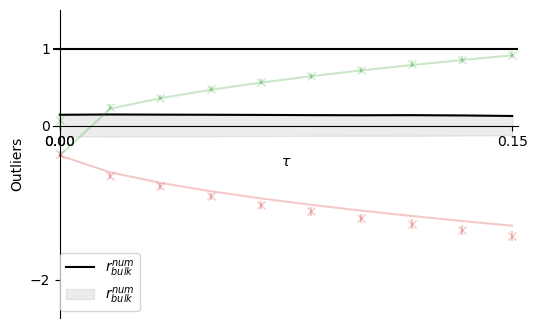

In [20]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius

### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(6,4))
### label is r_{bulk}^{num}
ax.plot(tau_series,np.mean(radius_num_map,axis=0),'k',label=r'$r_{bulk}^{num}$')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.15,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.legend()

alphass= 0.25

ax.plot(tau_series,eigvchn_theo[:,0],'tab:red',label='theoretical',alpha=alphass)
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green',alpha=alphass)

### plot error bar  
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:red',ecolor='tab:red',alpha=alphass,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=alphass,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
# ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
### plot y==1 
ax.axhline(y=1, color='k', linestyle='-')
plt.show()

In [24]:
# ### 
# trials = 36
# ntau = 10
# plt.close('all')
### compute the trial averaged mean 
mean_reigvec_series = np.zeros((trials,ntau,2,2)) ##rank, pop
mean_leigvec_series = np.zeros((trials,ntau,2,2)) ##rank, pop
mean_leig0vec_series = np.zeros((trials,ntau,2,2))
### numerical
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))
thl = 1.5
ths = 1.5
                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir]*eigvchn_series[ktrial,it,ir])
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir]*eigvchn_series[ktrial,it,ir])
            mean_leig0vec_num_series[ktrial,it,ir,0] = np.mean(eiglvec0_series[ktrial,it,:NE,ir])
            mean_leig0vec_num_series[ktrial,it,ir,1] = np.mean(eiglvec0_series[ktrial,it,NE:,ir])
            
## select the middle 30 values 
kktrial = np.arange(trials)
cuts = 5
for it in range(ntau):
    for ir in range(2):
        ### only keep the middle 30 values of mean_reigvec_series[:,it,ir,0/1], osrt mean_reigvec_series[:,it,ir,0]
        idxsort = np.argsort(mean_reigvec_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_series[idxnan,it,ir,1] = np.nan
        
        
        idxsort = np.argsort(mean_leigvec_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_series[idxnan,it,ir,0] = np.nan
    
            
        
        idxsort = np.argsort(mean_leigvec_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        
mean_rvec = np.zeros((ntau,2,2))
mean_lvec = np.zeros((ntau,2,2))

for it in range(ntau):
    for ir in range(2):
        for ip in range(2):
            mean_rvec[it,ir,ip] = np.nanmean(mean_reigvec_num_series[:,it,ir,ip])
            mean_lvec[it,ir,ip] = np.nanmean(mean_leigvec_num_series[:,it,ir,ip])#*eigvchn_theo[it,ir]
            
### compute the theoretical response function 
rank = 2
response_func_contribution = np.zeros((ntau,rank,2))
### compute the theoretical response function 
response_func = np.zeros((trials,ntau,2))
it = 0
response_func[:,it,1] = 1
for ir in range(1):
    response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
    response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
    
    response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
    response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)

    
for it in range(1,ntau):
    response_func[:,it,1] = 1
    if eigvchn_theo[it,1]<10:#np.mean(radius_num_map[:,it]):
        # response_func[:,it,:] = np.nan
        # response_func_contribution[it,:,:] = np.nan
        # continue  
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)  
    else:
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
        
        

C:\Users\Administrator\AppData\Local\Temp\ipykernel_46956\3132733486.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir]*eigvchn_series[ktrial,it,ir])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_46956\3132733486.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir]*eigvchn_series[ktrial,it,ir])


In [25]:
### 
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)
### numerical response function 
response_func_num = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
        response_func_num[ktrial,it,0]=(meanfr_pert[ktrial,it,0]-meanfr_eq[ktrial,it,0])/Ipert[-1]
        response_func_num[ktrial,it,1]=(meanfr_pert[ktrial,it,1]-meanfr_eq[ktrial,it,1])/Ipert[-1]
 
cuts = 10       
#### delete the largest 3 and the smallest 3 from response_func_num
for it in range(ntau):   
    idxsort = np.argsort(response_func_num[:,it,0].real)
    # print(response_func_num[idxsort,it,0])
    idxnan = idxsort[:cuts]#np.append(idxsort[:cuts],idxsort[-cuts:]) 
    response_func_num[idxnan,it,0] = np.nan
    
    idxsort = np.argsort(response_func_num[:,it,1].real)
    idxnan = idxsort[:cuts]#np.append(idxsort[:cuts],idxsort[-cuts:])
    response_func_num[idxnan,it,1] = np.nan
    
    ### find the eigenvalues > 1 
    idxeigv = np.where(np.abs(eigvchn_series[:,it,1])>1)
    idxsort = np.where(np.abs(response_func_num[:,it,0].copy())>1e1)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,0] = np.nan 
    
    idxsort = np.where(np.abs(response_func_num[:,it,1].copy())>1e1)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,1]  = np.nan 
    response_func_num[idxeigv,it,0] = np.nan
    response_func_num[idxeigv,it,1] = np.nan

Fig 11(b) Sparse network using SONETs

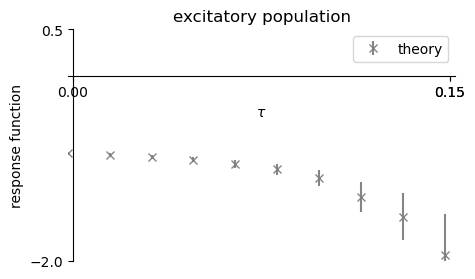

In [26]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
fige, axe = plt.subplots(figsize=(5,3))
# axe.plot(tau_series,response_func_contribution[:,0,0],'orange',marker='',alpha=0.36)
# axe.plot(tau_series,response_func_contribution[:,1,0],'green',marker='',alpha=0.36)
# axe.plot(tau_series,response_func_mean[:,0],'k',marker='')
### numerical using filled_between 
alphass = 0.95
axe.errorbar(tau_series[:]-dtau/8,response_func_num_mean[:,0],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,0],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
axe.set_xlabel(r'$\tau$')
axe.set_ylabel('response function')
axe.set_title('excitatory population')
axe.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
axe.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
axe.spines['top'].set_color('none')
axe.spines['right'].set_color('none')
axe.spines['left'].set_position(('data',tau_series[0]))
### set yaxis, ylim not too large!
axe.set_ylim([-2,2])
axe.set_yticks([-2,2])
axe.set_ylim([-2,0.5])
axe.set_yticks([-2,0.5])
axe.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
axe.set_xticks([tau_series[0],0.15,tau_series[-1]])
plt.show()

Fig 11(c) Sparse network using SONETs

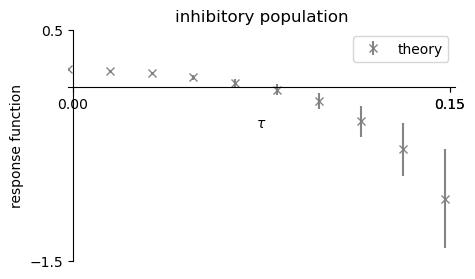

In [27]:
### compare response_func with response_func_num, average across the first dimension 
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
figi, axi = plt.subplots(figsize=(5,3))
# axi.plot(tau_series,response_func_contribution[:,0,1],'orange',marker='',alpha=0.36)
# axi.plot(tau_series,response_func_contribution[:,1,1],'green',marker='',alpha=0.36)
# axi.plot(tau_series,response_func_mean[:,1],'k',marker='')
alphass = 0.95
axi.errorbar(tau_series[:]-dtau/8,response_func_num_mean[:,1],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,1],fmt='x',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)

# ax.fill_between(tau_series,response_func_num_mean[:,1]+np.std(response_func_num[:,:,:],axis=0)[:,1],response_func_num_mean[:,1]-np.std(response_func_num[:,:,:],axis=0)[:,1],color='black',alpha=0.3)
# ax.plot(tau_series,response_func_num_mean[:,1],'r',marker='o')
axi.set_xlabel(r'$\tau$')
axi.set_ylabel('response function')
axi.set_title('inhibitory population')
axi.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
axi.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
axi.spines['top'].set_color('none')
axi.spines['right'].set_color('none')
axi.spines['left'].set_position(('data',tau_series[0]))
## set yaxis, ylim not too large!
axi.set_ylim([-1,1])
axi.set_ylim([-1,1.5])
axi.set_ylim([-1,0.5])
axi.set_ylim([-1.5,0.5])
axi.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
axi.set_xticks([tau_series[0],0.15,tau_series[-1]])
axi.set_yticks([-1.5,0.5])
plt.show()

#### Gaussian Approximation model

In [28]:
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"#ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_WD_AdjGau_22May_t200ms_PRX_N1500_nonneg_nonparadoxical_INHparadoxical.npz"#

# np.savez(data_name, **data)
### load data  
data = np.load(data_name,allow_pickle=True)
eigvchn_series = data['eigvchn_series']
eigrvec_series = data['eigrvec_series']
eiglvec_series = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
norml0_series = data['norml0_series']
params = data['params']
intg_ov_series = data['intg_ov_series']
first_perturb_ov = data['first_perturb_ov']
first_perturb_ovP = data['first_perturb_ovP']
intg_mean_series = data['intg_mean_series']
intg_std_series = data['intg_std_series']
intg_std_num_series = data['intg_std_num_series']

firing_rateeq = data['firing_rateeq']
firing_ratepert = data['firing_ratepert']

g = params[()]['g']
gamma = params[()]['gamma']
NE = params[()]['NE']
NI = params[()]['NI']
J = params[()]['J']
ce = params[()]['ce']
ci = params[()]['ci']
tau_series = params[()]['tau_series']

effective trials: [11 33  7 24 10 21 28 35  8  9 23 34 18  4 14 15  3 13 31 20 25  2 12 30
 27 16 32  1 19  0] 30


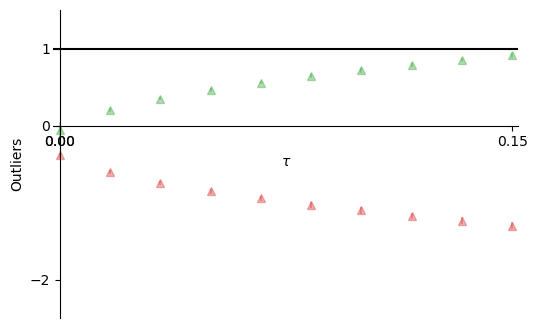

In [31]:
#### print trial by trial the first two eigenvallues
for ktrial in range(trials):
    eigvchn = eigvchn_series[ktrial,:,:].copy()
    eigvchn_real = (eigvchn)
# ### delete the 17th trial
# eigvchn_series = np.delete(eigvchn_series,17,axis=0) #for ConnStats_Adjacency_12OctDense_.npz
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius

alphass= 0.35
fig, ax = plt.subplots(figsize=(6,4))
### plot error bar  
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='^',color='tab:red',ecolor='tab:red',alpha=alphass,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='^',color='tab:green',ecolor='tab:green',alpha=alphass,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
# ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
### plot y==1 
ax.axhline(y=1, color='k', linestyle='-')
plt.show()

In [32]:
# ### 
# trials = 36
# ntau = 10
# plt.close('all')
### compute the trial averaged mean 
mean_reigvec_series = np.zeros((trials,ntau,2,2)) ##rank, pop
mean_leigvec_series = np.zeros((trials,ntau,2,2)) ##rank, pop
mean_leig0vec_series = np.zeros((trials,ntau,2,2))
### numerical
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))
thl = 1.5
ths = 1.5
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_series[ktrial,it,ir,0] = np.mean(intg_mean_series[ktrial,it,:NE,ir,1],axis=0)
            
            mean_reigvec_series[ktrial,it,ir,1] = np.mean(intg_mean_series[ktrial,it,NE:,ir,1],axis=0)
            
            mean_leigvec_series[ktrial,it,ir,0] = np.mean(intg_mean_series[ktrial,it,:NE,ir,0],axis=0)
            mean_leigvec_series[ktrial,it,ir,1] = np.mean(intg_mean_series[ktrial,it,NE:,ir,0],axis=0)
            # mean_leig0vec_series[ktrial,it,ir,0] = np.mean(leig0mean_series[ktrial,it,:NE,ir])
            # mean_leig0vec_series[ktrial,it,ir,1] = np.mean(leig0mean_series[ktrial,it,NE:,ir])
                
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir]*eigvchn_series[ktrial,it,ir].real)
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir]*eigvchn_series[ktrial,it,ir].real)
            mean_leig0vec_num_series[ktrial,it,ir,0] = np.mean(eiglvec0_series[ktrial,it,:NE,ir])
            mean_leig0vec_num_series[ktrial,it,ir,1] = np.mean(eiglvec0_series[ktrial,it,NE:,ir])
            
## select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6
for it in range(ntau):
    for ir in range(2):
        ### only keep the middle 30 values of mean_reigvec_series[:,it,ir,0/1], osrt mean_reigvec_series[:,it,ir,0]
        idxsort = np.argsort(mean_reigvec_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_series[idxnan,it,ir,1] = np.nan
        
        
        idxsort = np.argsort(mean_leigvec_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_series[idxnan,it,ir,0] = np.nan
    
            
        
        idxsort = np.argsort(mean_leigvec_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan
        
        
        

In [33]:
mean_rvec = np.zeros((ntau,2,2))
mean_lvec = np.zeros((ntau,2,2))

for it in range(ntau):
    for ir in range(2):
        for ip in range(2):
            mean_rvec[it,ir,ip] = np.nanmean(mean_reigvec_num_series[:,it,ir,ip])
            mean_lvec[it,ir,ip] = np.nanmean(mean_leigvec_num_series[:,it,ir,ip])#*eigvchn_theo[it,ir]
            
### compute the theoretical response function 
rank = 2
response_func_contribution = np.zeros((ntau,rank,2))
### compute the theoretical response function 
response_func = np.zeros((trials,ntau,2))
it = 0
response_func[:,it,1] = 1
for ir in range(1):
    response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
    response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
    
    response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
    response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)

    
for it in range(1,ntau):
    response_func[:,it,1] = 1
    if eigvchn_theo[it,1]<10:#np.mean(radius_num_map[:,it]):
        # response_func[:,it,:] = np.nan
        # response_func_contribution[it,:,:] = np.nan
        # continue  
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)

    
    else:
        for ir in range(2):
            response_func[:,it,0] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func[:,it,1] += (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
            
            response_func_contribution[it,ir,0] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,0]))/(1-eigvchn_theo[it,ir].real)
            response_func_contribution[it,ir,1] = (NI*(mean_lvec[it,ir,1])*(mean_rvec[it,ir,1]))/(1-eigvchn_theo[it,ir].real)
        

In [34]:
### 
meanfr_eq = np.zeros((trials,ntau,2))
meanfr_pert = np.zeros((trials,ntau,2))
meanfr_eq[:,:,0] = np.mean(firing_rateeq[:,:,:NE],axis=2)
meanfr_eq[:,:,1] = np.mean(firing_rateeq[:,:,NE:],axis=2)
### same for pydll Creates ()
meanfr_pert[:,:,0] = np.mean(firing_ratepert[:,:,:NE],axis=2)
meanfr_pert[:,:,1] = np.mean(firing_ratepert[:,:,NE:],axis=2)
### numerical response function 
response_func_num = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
        response_func_num[ktrial,it,0]=(meanfr_pert[ktrial,it,0]-meanfr_eq[ktrial,it,0])/Ipert[-1]
        response_func_num[ktrial,it,1]=(meanfr_pert[ktrial,it,1]-meanfr_eq[ktrial,it,1])/Ipert[-1]
        
#### delete the largest 3 and the smallest 3 from response_func_num
for it in range(ntau):
    idxsort = np.where(np.abs(response_func_num[:,it,0].copy())>10)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,0] = np.nan 
    
    
    idxsort = np.where(np.abs(response_func_num[:,it,1].copy())>10)
    idxnan = (idxsort) 
    response_func_num[idxnan,it,1] = np.nan 

Fig 11(b) Gaussian Approximation model

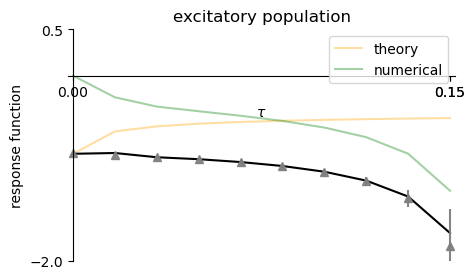

In [35]:
### compare response_func with response_func_num, average across the first dimension 
fige, axe = plt.subplots(figsize=(5,3))
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
# fige, axe = plt.subplots(figsize=(5,3))
axe.plot(tau_series,response_func_contribution[:,0,0],'orange',marker='',alpha=0.36)
axe.plot(tau_series,response_func_contribution[:,1,0],'green',marker='',alpha=0.36)
axe.plot(tau_series,response_func_mean[:,0],'k',marker='')
# ### numerical using filled_between 
alphass = 0.95
axe.errorbar(tau_series[:],response_func_num_mean[:,0],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,0],fmt='^',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)

axe.set_xlabel(r'$\tau$')
axe.set_ylabel('response function')
axe.set_title('excitatory population')
axe.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
axe.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
axe.spines['top'].set_color('none')
axe.spines['right'].set_color('none')
axe.spines['left'].set_position(('data',tau_series[0]))
### set yaxis, ylim not too large!
axe.set_ylim([-2,2])
axe.set_yticks([-2,2])
axe.set_ylim([-2,0.5])
axe.set_yticks([-2,0.5])
axe.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
axe.set_xticks([tau_series[0],0.15,tau_series[-1]])
plt.show()

Fig 11(c) Gaussian Approximation model

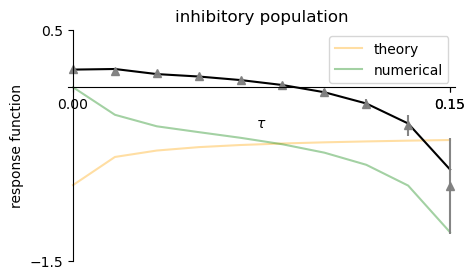

In [36]:
### compare response_func with response_func_num, average across the first dimension '
figi, axi = plt.subplots(figsize=(5,3))
dtau = tau_series[1]-tau_series[0]
response_func_mean = np.nanmean(response_func[:,:,:],axis=0)
response_func_num_mean = np.nanmean(response_func_num[:,:,:],axis=0)
# figi, axi = plt.subplots(figsize=(5,3))
axi.plot(tau_series,response_func_contribution[:,0,1],'orange',marker='',alpha=0.36)
axi.plot(tau_series,response_func_contribution[:,1,1],'green',marker='',alpha=0.36)
axi.plot(tau_series,response_func_mean[:,1],'k')
alphass = 0.95
axi.errorbar(tau_series[:],response_func_num_mean[:,1],yerr=np.nanstd(response_func_num[:,:,:],axis=0)[:,1],fmt='^',color='tab:gray',ecolor='tab:gray',alpha=alphass,ls='',elinewidth=1.5)

axi.set_xlabel(r'$\tau$')
axi.set_ylabel('response function')
axi.set_title('inhibitory population')
axi.legend(['theory','numerical'])
### move x-axis at data 0, y-axis at 0 
axi.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
axi.spines['top'].set_color('none')
axi.spines['right'].set_color('none')
axi.spines['left'].set_position(('data',tau_series[0]))
## set yaxis, ylim not too large!
axi.set_ylim([-1,1])
axi.set_ylim([-1,1.5])
axi.set_ylim([-1,0.5])
axi.set_ylim([-1.5,0.5])
axi.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
axi.set_xticks([tau_series[0],0.15,tau_series[-1]])
axi.set_yticks([-1.5,0.5])
plt.show()

Single backup

In [501]:
# trials = 36
# alphachns     = ['0.000','0.100','0.200','0.300','0.400','0.500','0.600','0.700','0.800','0.900']
# alphachns_rec = ['0.000','0.200','0.400','0.600','0.800','1.000','1.200','1.400','1.600','1.800']
# # alphachns_arr = np.array([0.1,0.2,0.3,0.4])
# eigvchn_series = np.zeros((trials,1,N),dtype=complex)
# # tauchns_arr = alphachns_arr*c**2/c/(1-c)
# seedss = np.array([1, 4, 8, 10, 13, 14, 18, 19, 25, 26, 31, 32, 34, 36, 40, 43, 44, 49, 52, 53, 55 ,60, 62, 64, 71, 73, 76, 78, 81, 82, 83,84, 85, 86, 87, 88, 93, 94, 95])
# seedss = np.arange(1,37)
# for ktrial in range(trials):
#     seed =seedss[ktrial]
#     z_pre = 0
#     idxalpha,alphachn=6,0.6

#     file_path = 'J:\\Allen_motif\\PRXL_data\\sonets\\N1750_FIXNUM\\seed_'+str(seed)+'\\w_1750_0.171_'+alphachns_rec[idxalpha]+'_'+alphachns[idxalpha]+'_'+alphachns[idxalpha]+'_1.000_'+str(seed)+'.dat'
#     # file_path = '/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/sonets/data/data
#     Jmat = np.zeros((N,N))
#     count =0
#     with open(file_path, 'r') as file:
#         content = file.read()
#         if content == '0':
#             print('File is empty') 
#         else:
#             for line in content.split('\n'):
#                 if line:
#                     Jmat[count,:]=([(x) for x in line.split()])
#                     count +=1
#     # ### adding excitatory and inhibitory  
#     # Zmat2 = (Jmat-c)@(Jmat-c)
#     # chainsum = 0
#     # for i in range(1000):
#     #     for j in range(1000):
#     #         if i!=j:
#     #             chainsum += Zmat2[i,j]
#     # print('chainsum,',chainsum/1000/999)           
#     Jmat[:,:NE] = Jmat[:,:NE]*je
#     Jmat[:,NE:] = Jmat[:,NE:]*(-ji)

#     ktrial, it = ktrial, 0

#     ### compute the eigenvalues and eigenvectors of the matrix
#     eigvchn, eigrvec = la.eig(Jmat)
#     ## sort the eigenValues by it's norm of the real part 
#     idxeigv = np.argsort(np.abs(eigvchn))
#     idxeigv = idxeigv[::-1]
#     eigvchn, eigrvec = eigvchn[idxeigv],eigrvec[:,idxeigv]
    
#     eigvchn_,eiglvec = la.eig(Jmat.copy().T)
#     idxeigv = np.argsort(np.abs(eigvchn_))
#     idxeigv = idxeigv[::-1]
#     eigvchn_, eiglvec = eigvchn[idxeigv],eiglvec[:,idxeigv]
    
#     ### normalization
#     reig    = np.squeeze(eigrvec[:,:].copy())
#     leig0   = np.squeeze(eiglvec[:,:].copy()) 
#     normval = np.sum(reig.copy()*leig0.copy(),axis=0)
    
#     normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
#     leig = leig0.copy()/normval.copy()### left eigenvector normalization to make <l|r>=1
#     if np.mean(reig[:NE,0])<0:
#         reig[:,0]*=-1
#         leig[:,0]*=-1
#         leig0[:,0]*=-1
#     if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
#         reig[:,1]*=-1
#         leig[:,1]*=-1
#         leig0[:,1]*=-1    
            
#     print('seed:',seed,'alphachn:',alphachn,'idxalpha:',idxalpha)
#     print('eigenvalues',eigvchn[:2])
    
    
#     eigvchn_series[ktrial,it,:] = eigvchn[:] 

Save data

In [ ]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d